In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# pytorch封装卷积层
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        
        #定义个三层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
    
        )
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, X):
        out = self.conv(X)
        out = F.avg_pool2d(out, 26)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [3]:
# 训练函数
def train_epoch(net, data_loader, device):
    net.train() # 指定当前为训练模式
    train_batch_num = len(data_loader) # 记录共有多少个batch
    total_loss = 0 # 记录loss
    correct = 0 # 记录共有多少个样本被正确分类
    sample_num = 0 # 记录样本总数
    
    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float() # 将图片放入指定的device中
        target = target.to(device).long() # 将图片标签放入到指定的device中
        optimizer.zero_grad() # 将当前梯度清零
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        prediction = torch.argmax(output, 1) # 找出每个样本值最大的idx, 即岱庙预测此图片属于哪个类别
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

In [4]:
# 测试函数
def test_epoch(net, data_loader, device):
    net.eval() # 指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    # 指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
            
        loss = total_loss / test_batch_num
        acc = correct / sample_num
        return loss, acc

In [5]:
# 读取数据
data_dir = './data'

# 定义一个transform操作，用户将torch中的数据转换为可以输入到我们模式的形式
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) 
    ]
) # 将数据归一化

#获取cifar-10数据集并进行transform
cifar_train = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True,transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True,transform=transform)

# cifar-10数据集对应10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = 10
epochs = 100
lr = 0.001
batch_size = 512
device = torch.device('cpu') # 如使用0号GPU则填写 ‘cuda:1’

#生成dataloader
cifar_trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers = 0)
cifar_testloader = torch.utils.data.DataLoader(cifar_test, batch_size=512, shuffle=True, num_workers=0)

print(len(cifar_trainloader))
print(len(cifar_testloader))

# 初始化模型
net = ConvModule().to(device)

# 使用多元交叉熵损失
criterion = nn.CrossEntropyLoss()

# 使用Adam优化器
optimizer = optim.Adam(net.parameters(), lr=lr)

Files already downloaded and verified
Files already downloaded and verified
98
20


In [6]:
# 存储每个epoch的Loss与acc的变化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 进行训练
for epoch in range(epochs):
    # 在训练集上训练
    train_loss, train_acc = train_epoch(net, data_loader=cifar_trainloader, device=device)
    # 在测试集上验证
    test_loss, test_acc = test_epoch(net, data_loader=cifar_testloader, device=device)
    # 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    print(f'epoch:{epoch}\t train_loss:{train_loss:.4f} \t'
          f'train_acc:{train_acc} \t'
          f'test_loss:{test_loss:.4f} \t test_acc:{test_acc}'
         )

epoch:0	 train_loss:1.7393 	train_acc:0.3797 	test_loss:1.5393 	 test_acc:0.4403
epoch:1	 train_loss:1.4169 	train_acc:0.5016 	test_loss:1.3510 	 test_acc:0.5205
epoch:2	 train_loss:1.2781 	train_acc:0.55008 	test_loss:1.3476 	 test_acc:0.4997
epoch:3	 train_loss:1.2003 	train_acc:0.57414 	test_loss:1.2331 	 test_acc:0.5474
epoch:4	 train_loss:1.1445 	train_acc:0.59836 	test_loss:1.1719 	 test_acc:0.5838
epoch:5	 train_loss:1.0954 	train_acc:0.61712 	test_loss:1.1458 	 test_acc:0.5844
epoch:6	 train_loss:1.0633 	train_acc:0.62658 	test_loss:1.1144 	 test_acc:0.6003
epoch:7	 train_loss:1.0344 	train_acc:0.63744 	test_loss:1.5091 	 test_acc:0.4765
epoch:8	 train_loss:1.0024 	train_acc:0.6509 	test_loss:1.1036 	 test_acc:0.6012
epoch:9	 train_loss:0.9844 	train_acc:0.65746 	test_loss:1.1221 	 test_acc:0.6017
epoch:10	 train_loss:0.9603 	train_acc:0.6648 	test_loss:1.3053 	 test_acc:0.5472
epoch:11	 train_loss:0.9406 	train_acc:0.67552 	test_loss:1.0022 	 test_acc:0.6425
epoch:12	 train_lo

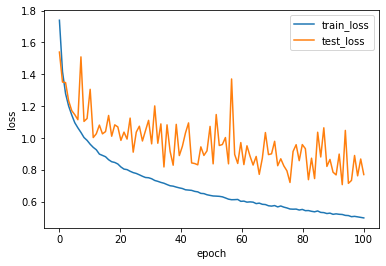

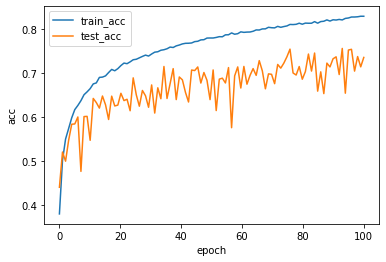

In [8]:
#画图
x = np.linspace(0, len(train_loss_list), len(train_loss_list))
plt.plot(x, train_loss_list, label = 'train_loss', linewidth=1.5)
plt.plot(x, test_loss_list, label='test_loss', linewidth = 1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

y = np.linspace(0, len(train_acc_list), len(train_acc_list))
plt.plot(y, train_acc_list, label = 'train_acc', linewidth=1.5)
plt.plot(y, test_acc_list, label='test_acc', linewidth = 1.5)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()